# Chapter 10. Boosting and Additive trees

## 10.1: Boosting methods

In [11]:
# Import dependent packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
plt.style.use('seaborn')
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold


from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import accuracy_score

In [2]:
### Function takes two feature transform methods: normalization and MiniMaxScale
def feature_prerpocess(data, form = 'normal'):
    if form == "normal":
        new_data = scale(data)
    elif form == "MinMax":
        new_data = minmax_scale(data)
    return pd.DataFrame(new_data)

The motivation for boosting was a procedure that combines the outputs of many "weak" classifiers to produce a powerful "committee". One of the most popular boosting algorithms is "AdaBoost".

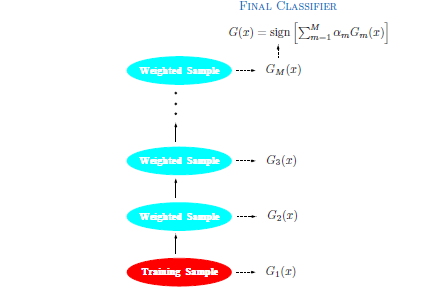

In [3]:
Image(filename='boosting.png', width=600,  height =100) 

**AdaBoost algorithm:**
1. Initialize the observation weights $w_i=\frac{1}{N}, i=1,2,...,N$ <br/><br/>
2. For $m=1$ to $M$:
 
 a) Fit a classifier $G_m(X)$ to the training data using weights $w_i$

 b) Compute
\begin{equation}
\hat{err_{m}} = \frac{\sum_{i=1}^{N}w_iI(y_i \neq G_m(x_i))}{\sum_{i=1}^{N}w_i} 
\end{equation}

 c) Compute $\alpha_m = log(\frac{1-err_m}{err_m})$ 

 d) Set $w_i \leftarrow w_i exp[\alpha_mI(y_i \neq G_m(x_i))], i=1,2,...,N$ <br/><br/>
 
3. Output $G(x)=sign[\sum_{m=1}^{M}\alpha_mG_m(X)]$

**SAMME.R algorithm:**
1. Initialize the observation weights $w_i=\frac{1}{N}, i=1,2,...,N$ <br/><br/>
2. For $m=1$ to $M$:
 
 a) Fit a classifier $G_m(X)$ to the training data using weights $w_i$
 
 b) Obtain the weighted class $(k)$ probability estimates
\begin{equation}
p_k^{(m)}(x)=Pr_w(c=k|x), k=1,...,K
\end{equation}

 c) Set 
\begin{equation}
h_k^{(m)}(x)\leftarrow (K-1)\left( logp_k^{(m)}(x)-\frac{1}{K}\sum_{k'}^{}logp^{(m)}_{k'}(x) \right), k=1,...,K
\end{equation}

 d) Set 
\begin{equation}
w_i \leftarrow w_i exp \left( -\frac{K-1}{K} y_i^t logp^{(m)} (x_i) \right)
\end{equation}

 e) Re-normalize $w_i$ <br/><br/>
 
3. Output 
\begin{equation}
C(x)=\substack{argmax\\k} \sum_{m=1}^{M}h_k^{(m)}(x)
\end{equation}


In [4]:
#Download data 
Audit = pd.read_csv('audit_risk.csv', sep=',', encoding= 'unicode_escape')
X_matrix = Audit.iloc[:, 3:6]
y_var = Audit.iloc[:, -1] 

# Split dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_matrix, y_var, test_size=0.30)

#Build the models
adaboost_classifier = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 1),
                                          learning_rate = 0.08, algorithm = 'SAMME', random_state = 0)
adaboost_classifier_r = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 1),
                                          learning_rate = 0.08, algorithm = 'SAMME.R', random_state = 0)
models = [adaboost_classifier, adaboost_classifier_r]
models_names = ["Adaboost", "SAMME.R"]

for i,j in zip(models_names, models):
    search = GridSearchCV(j, cv=10, n_jobs=-1, verbose=5,
                    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [10, 20, 30, 40, 50, 70, 100] })
    search.fit(X_train, Y_train)
    print("Best parameter (CV score=%0.3f)"% search.best_score_+" "+i+":" )
    print(search.best_params_)
    print("Accuracy for test dataset"+" "+i+":"+ str(1-np.sum(np.absolute(search.predict(X_test)-Y_test))/len(Y_test)))

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    7.9s finished


Best parameter (CV score=0.841) Adaboost:
{'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 100}
Accuracy for test dataset Adaboost:0.8240343347639485
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.7s


Best parameter (CV score=0.869) SAMME.R:
{'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 10}
Accuracy for test dataset SAMME.R:0.8712446351931331


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    6.3s finished


The comparison of "AdaBoost.M1" and "SAMME.R" algorithms for binary classification problem.

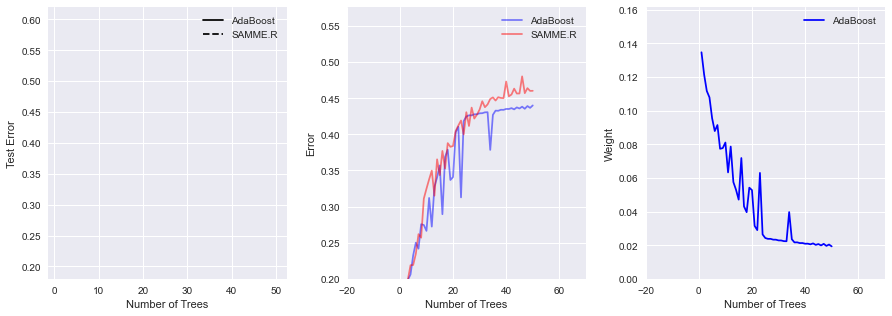

In [5]:
bdt_real = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 1),
                                          learning_rate = 0.08, algorithm = 'SAMME.R', random_state = 0)

bdt_discrete = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 1),
                                         learning_rate = 0.08, algorithm = 'SAMME', random_state = 0)

bdt_real.fit(X_train, Y_train)
bdt_discrete.fit(X_train, Y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, Y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, Y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='AdaBoost')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='AdaBoost', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='AdaBoost')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

## 10.1: Boosting trees

**Gradient Tree Boosting Algorithm:**
1. Initialize $f_0(x)=argmin_\tau \sum_{i=1}^{N} L(y_i,\tau)$ <br/><br/>
2. For $m=1$ to $M$:

 a) For $i=1,2,...,N$ compute
\begin{equation}
r_{im}=- \{\frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}\}_{f=f_{m-1}}
\end{equation}
 
 b) Fit a regression tree to the targets $r_im$ giving terminal regions $R_{jm}, j=1,2,...,J_m$
 
 c) For $j=1,2,...,J_m$ compute
\begin{equation}
\tau_{im}= \substack{argmin\\ \tau} \sum_{x_i \in R_{jm}}^{} L(y_i, f_{m-1}(x_i)+ \tau)
\end{equation}

 d) Update $f_m(x)=f_{m-1}(x) + \sum_{j=1}^{J_m} \tau_{jm} I(x \in R_{jm})$ <br/><br/>

3. Output $\hat{f(x)}=f_M(x)$

In [6]:
#Download data 
Seoul_bike = pd.read_csv('SeoulBikeData.csv', sep=',', encoding= 'unicode_escape')
Seoul_bike

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [7]:
X_matrix = Seoul_bike.iloc[:100, 3:6]
y_var = Seoul_bike.iloc[:100, 1:2]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

In [39]:
search = GridSearchCV(GradientBoostingRegressor(), cv=10, n_jobs=-1, verbose=5,
                    param_grid = {"learning_rate" : [0.1, 0.2],
              "n_estimators" :   [3,5,10, 30,50,70,80,100],
              "max_depth" :   [2, 3,4]})
search.fit(X_train, y_train)

print('Train R^2 Score : %.3f'%search.best_estimator_.score(X_train, y_train))
print('Test R^2 Score : %.3f'%search.best_estimator_.score(X_test, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%search.best_score_)
print('Best Parameters : ',search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 427 tasks      | elapsed:    1.6s


Train R^2 Score : 0.558
Test R^2 Score : 0.398
Best R^2 Score Through Grid Search : 0.173
Best Parameters :  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    1.9s finished
